# Bayesian Inference for Randomized Benchmarking


## Introduction

This notebook gives an example of how to use Bayesian inference as a help for randomized benchmarking. The Pymc3 and Arviz python packages are used for this purpose. Priors are obtained from the fitter included in the Qiskit ``ignis.verification.randomized_benchmarking``module. A pooled and a hierarchical model are tested and compared. The model's parameters are ajusted and the error per Clifford (EPC) is estimated, together with a credible interval. For reference, an EPC value is calculated from the noisy model of the simulation.

Thes notebook is based on the examples of the ignis noise tutorial on randomized benchmarking.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

import copy

# import the bayesian packages
import pymc3 as pm
import arviz as az

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def obtain_priors_and_data_from_fitter(printout = True):
    m_gates = copy.deepcopy(nCliffs)
    # We choose the count matrix corresponding to 2 Qubit RB
    Y = (np.array(rbfit._raw_data[0])*shots).astype(int)
    
    # alpha prior and bounds 
    alpha_ref = rbfit._fit[0]['params'][1]    
    alpha_lower = alpha_ref - 5*rbfit._fit[0]['params_err'][1]
    alpha_upper = alpha_ref + 5*rbfit._fit[0]['params_err'][1]
    
    # priors for A anbd B
    mu_AB = np.delete(rbfit._fit[0]['params'],1)
    cov_AB=np.delete(rbfit._fit[0]['params_err'],1)**2
    
    # prior for sigmatheta:
    sigma_theta = 0.004    
    if printout:
        print("priors:\nalpha_ref",alpha_ref)
        print("alpha_lower", alpha_lower, "alpha_upper", alpha_upper)
        print("A,B", mu_AB, "\ncov A,B", cov_AB)
        print("sigma_theta", sigma_theta)
    
    return m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta

In [4]:
def get_bayesian_model(model_type):
# Bayesian model
# from https://iopscience.iop.org/article/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RB_model = pm.Model()
    with RB_model:
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))

        # Expected value of outcome
        GSP = AB[0]*alpha**m_gates + AB[1]
        
        if model_type == "pooled":
            total_shots = np.full(Y.shape, shots)
            theta = GSP
        
        elif model_type == "hierarchical":
            total_shots = np.full(Y.shape, shots)
            theta = pm.Beta("GSP",
                         mu=GSP,
                         sigma = sigma_theta,
                         shape = Y.shape[1])
        
        # Likelihood (sampling distribution) of observations    
        p = pm.Binomial("Counts", p=theta, observed=Y,
                            n = total_shots) 

    return RB_model

In [5]:
def get_trace(RB_model):
    # Gradient-based sampling methods
    # see also: https://docs.pymc.io/notebooks/sampler-stats.html
    # and https://docs.pymc.io/notebooks/api_quickstart.html
    with RB_model:   
        trace= pm.sample(draws = 2000, tune= 10000, target_accept=0.9, return_inferencedata=True)    

    with RB_model:
        az.plot_trace(trace);
        
    return trace

In [6]:
def get_summary(RB_model, trace, hdi_prob=.94, kind='all'):
    with RB_model:
        #  (hdi_prob=.94 is default)
        az_summary = az.summary(trace, round_to=4,  hdi_prob=hdi_prob, kind=kind )  
        
    return az_summary

In [7]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return 3*(1-alpha)/4   

In [8]:
def get_EPC_and_legends(azs):
    EPC_Bayes = alpha_to_EPC(azs['mean']['alpha'])
    EPC_Bayes_err = EPC_Bayes - alpha_to_EPC(azs['mean']['alpha']+azs['sd']['alpha'])
    Bayes_legend ="EPC Bayes {0:.5f} ({1:.5f})".format(EPC_Bayes, EPC_Bayes_err)
    Fitter_legend ="EPC Fitter {0:.5f} ({1:.5f})".format(rbfit.fit[0]['epc']\
                                                        ,rbfit._fit[0]['epc_err'])
    pred_epc_legend = "EPC predicted {0:.5f}".format(pred_epc)
    return EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend
    
def EPC_compare_fitter_to_bayes(RB_model, azs, trace):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend = get_EPC_and_legends(azs)
    with RB_model:
        az.plot_posterior(trace,  var_names=['alpha'], round_to=4,
                          transform = alpha_to_EPC, point_estimate=None)
        plt.title("Error per Clifford")
        plt.axvline(x=alpha_to_EPC(alpha_ref),color='red')
        plt.axvline(x=pred_epc,color='green')
        plt.legend((Bayes_legend, "Higher density interval",Fitter_legend, pred_epc_legend), fontsize=10 )
        plt.show()

In [9]:
def GSP_compare_fitter_to_bayes(RB_model, azs):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend,_ = get_EPC_and_legends(azs)
    # plot ground state population ~ Clifford length
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

    axes.set_ylabel("Ground State Population")
    axes.set_xlabel("Clifford Length")
    axes.plot(m_gates, np.mean(Y/shots,axis=0), 'r.')
    axes.plot(m_gates,azs['mean']['AB[0]']*azs['mean']['alpha']**m_gates+azs['mean']['AB[1]'],'--')
    axes.plot(m_gates,mu_AB[0]*np.power(alpha_ref,m_gates)+mu_AB[1],':') 
    for i_seed in range(nseeds):
        plt.scatter(m_gates, Y[i_seed,:]/shots, label = "data", marker="x")
    axes.legend(["Mean Observed Frequencies",
                 "Bayesian Model\n"+Bayes_legend,
                 "Fitter Model\n"+Fitter_legend],fontsize=12)
    #axes.set_title('2 Qubit RB with T1/T2 Noise', fontsize=18)

In [10]:
def get_predicted_EPC(error_source):

    #Count the number of single and 2Q gates in the 2Q Cliffords
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                      np.mean([gates_per_cliff[rb_pattern[0][0]][basis_gate],
                                                               gates_per_cliff[rb_pattern[0][1]][basis_gate]])))
    # Calculate the predicted epc
    # from the known depolarizing errors on the simulation
    if error_source == "depolarization":  
        # Error per gate from noise model
        epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
        epg_2q = p2Q*3/4
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 2],
            list_epgs_1q=[epgs_1q, epgs_1q])

    # using the predicted primitive gate errors from the coherence limit
    if error_source == "from_T1_T2": 
        # Predicted primitive gate errors from the coherence limit
        u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q)
        u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q)
        epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
        epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 1],
            list_epgs_1q=[epgs_1q, epgs_1q])
    return pred_epc

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

# 1. Run an RB Sequence with one- and two-qubit Clifford gate sequences simultaneously.



In [11]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 8
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,2],[1]]
#Do three times as many 1Q Cliffords
length_multiplier = [1,3]

In [12]:
rb_pattern[0][1]

2

In [13]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [14]:
print(rb_circs[0][0])

      ┌───┐┌───┐     ┌───┐┌───┐      ░ ┌─────┐┌───┐              ┌───┐ ┌───┐   »
qr_0: ┤ X ├┤ H ├──■──┤ H ├┤ S ├──────░─┤ SDG ├┤ H ├──────────■───┤ H ├─┤ X ├───»
      ├───┤├───┤  │  └─░─┘├───┤┌───┐ ░ └┬───┬┘├───┤ ░ ┌───┐  │  ┌┴───┴┐├───┤ ░ »
qr_1: ┤ X ├┤ S ├──┼────░──┤ Z ├┤ S ├────┤ H ├─┤ S ├─░─┤ X ├──┼──┤ SDG ├┤ H ├─░─»
      ├───┤├───┤┌─┴─┐  ░  └───┘└───┘ ░  └───┘ └───┘ ░ └───┘┌─┴─┐├─────┤├───┤┌─┐»
qr_2: ┤ Z ├┤ S ├┤ X ├────────────────░─────────────────────┤ X ├┤ SDG ├┤ Z ├┤M├»
      └───┘└───┘└───┘                ░                     └───┘└─────┘└───┘└╥┘»
cr: 3/═══════════════════════════════════════════════════════════════════════╩═»
                                                                             1 »
«      ┌─┐        
«qr_0: ┤M├────────
«      └╥┘┌───┐┌─┐
«qr_1: ─╫─┤ Z ├┤M├
«       ║ └───┘└╥┘
«qr_2: ─╫───────╫─
«       ║       ║ 
«cr: 3/═╩═══════╩═
«       0       2 


In [15]:
noise_model = NoiseModel()
p1Q = 0.004 # this was doubled with respect to the original example
p2Q = 0.02 # this was doubled with respect to the original example
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [16]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
result_list = []
transpile_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed,
                                         basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model,
                         shots=shots,
                         backend=backend, max_parallel_experiments=0)
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Compiling seed 5
Simulating seed 5
Compiling seed 6
Simulating seed 6
Compiling seed 7
Simulating seed 7
Finished Simulating


In [17]:
#Create an RBFitter object
rbfit = rb.fitters.RBFitter(result_list, xdata, rb_opts['rb_pattern'])

##  Bayesian inference


In [18]:
m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(printout = True)

priors:
alpha_ref 0.9584901446793573
alpha_lower 0.9525710521018751 alpha_upper 0.9644092372568396
A,B [0.72228928 0.24803668] 
cov A,B [1.50940855e-04 4.69237320e-06]
sigma_theta 0.004


### pooled model

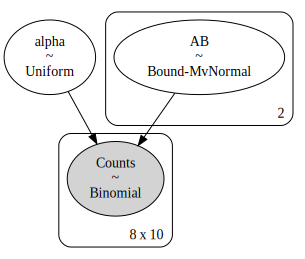

In [19]:
pooled = get_bayesian_model("pooled")
pm.model_to_graphviz(pooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 26 seconds.


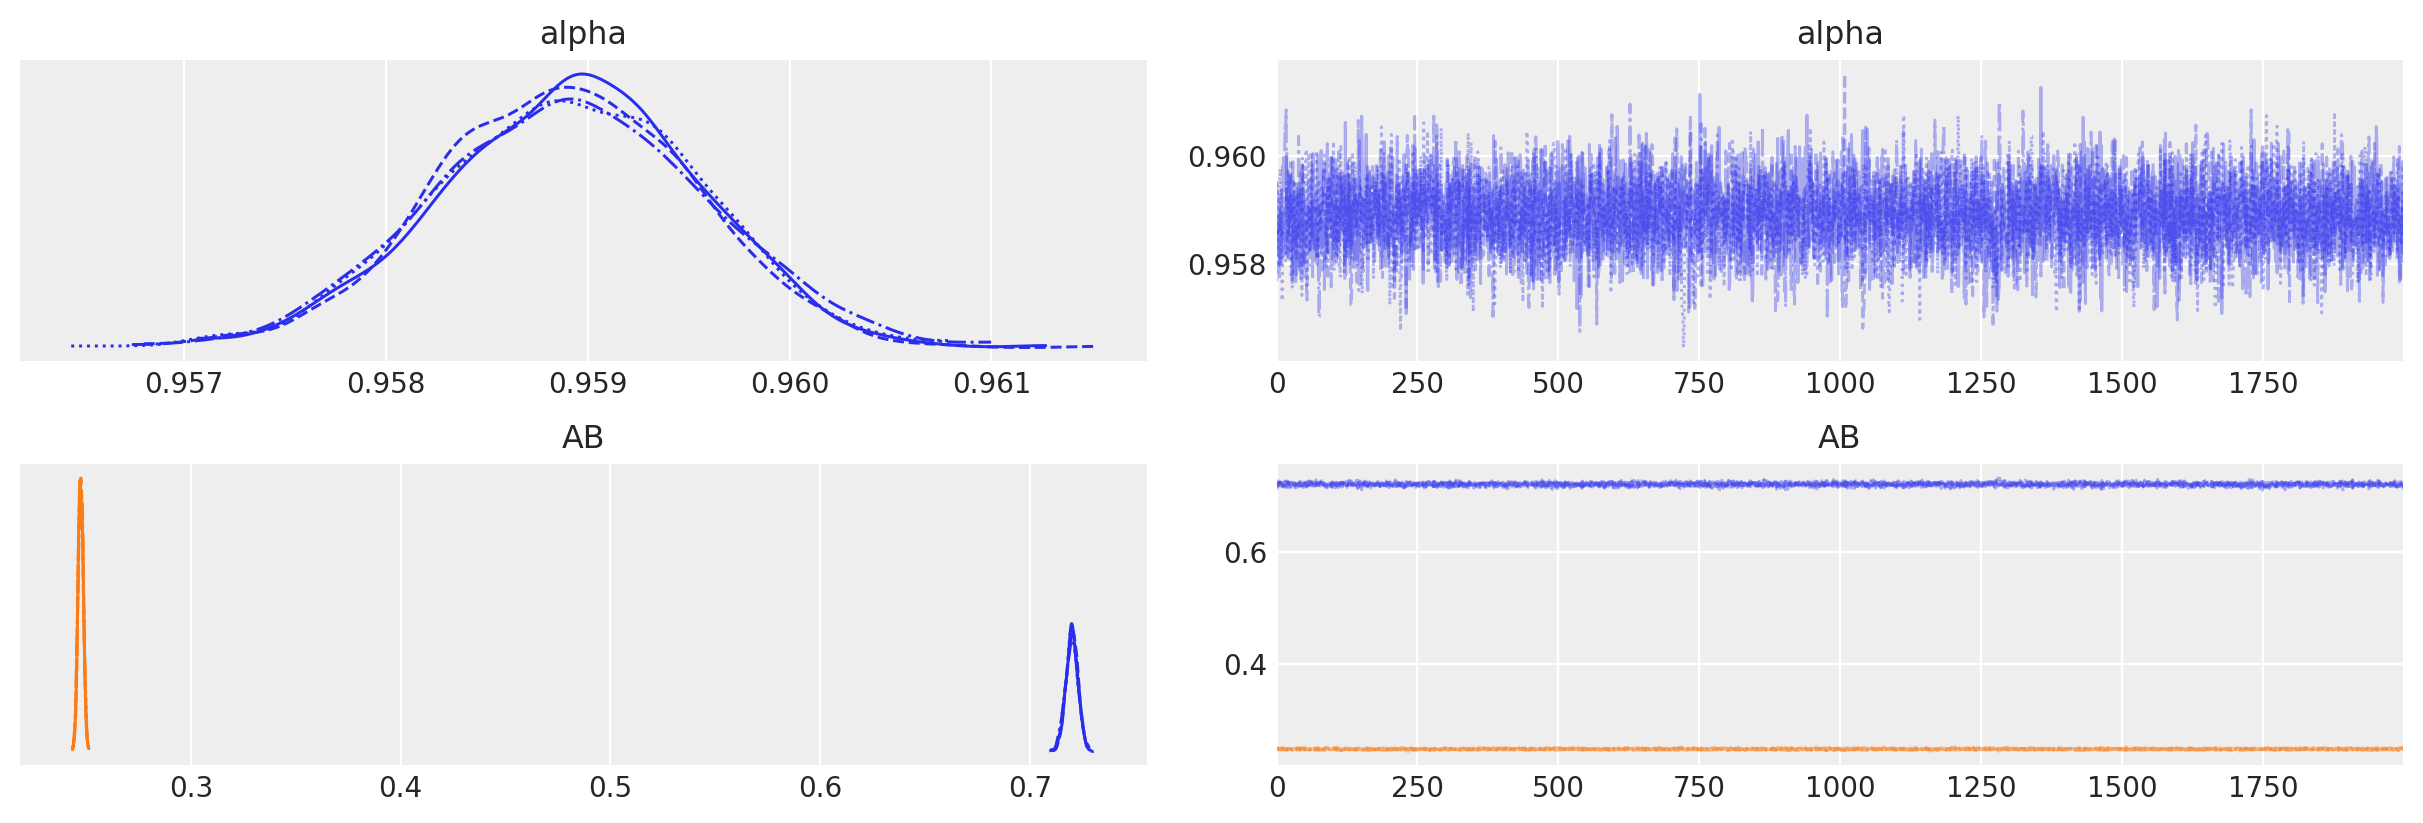

In [20]:
trace_p = get_trace(pooled)

In [21]:
azp_summary = get_summary(pooled, trace_p)
azp_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9589,0.0006,0.9577,0.9601,0.0,0.0,4990.6721,5246.7988,1.0007
AB[0],0.7198,0.0029,0.7144,0.7254,0.0,0.0,5048.5340,4381.0037,1.0008
AB[1],0.2476,0.0012,0.2453,0.2499,0.0,0.0,5097.5221,4958.0346,1.0004


### hierarchical model

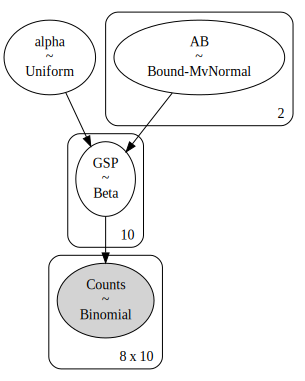

In [22]:
hierarchical = get_bayesian_model("hierarchical")
pm.model_to_graphviz(hierarchical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 35 seconds.


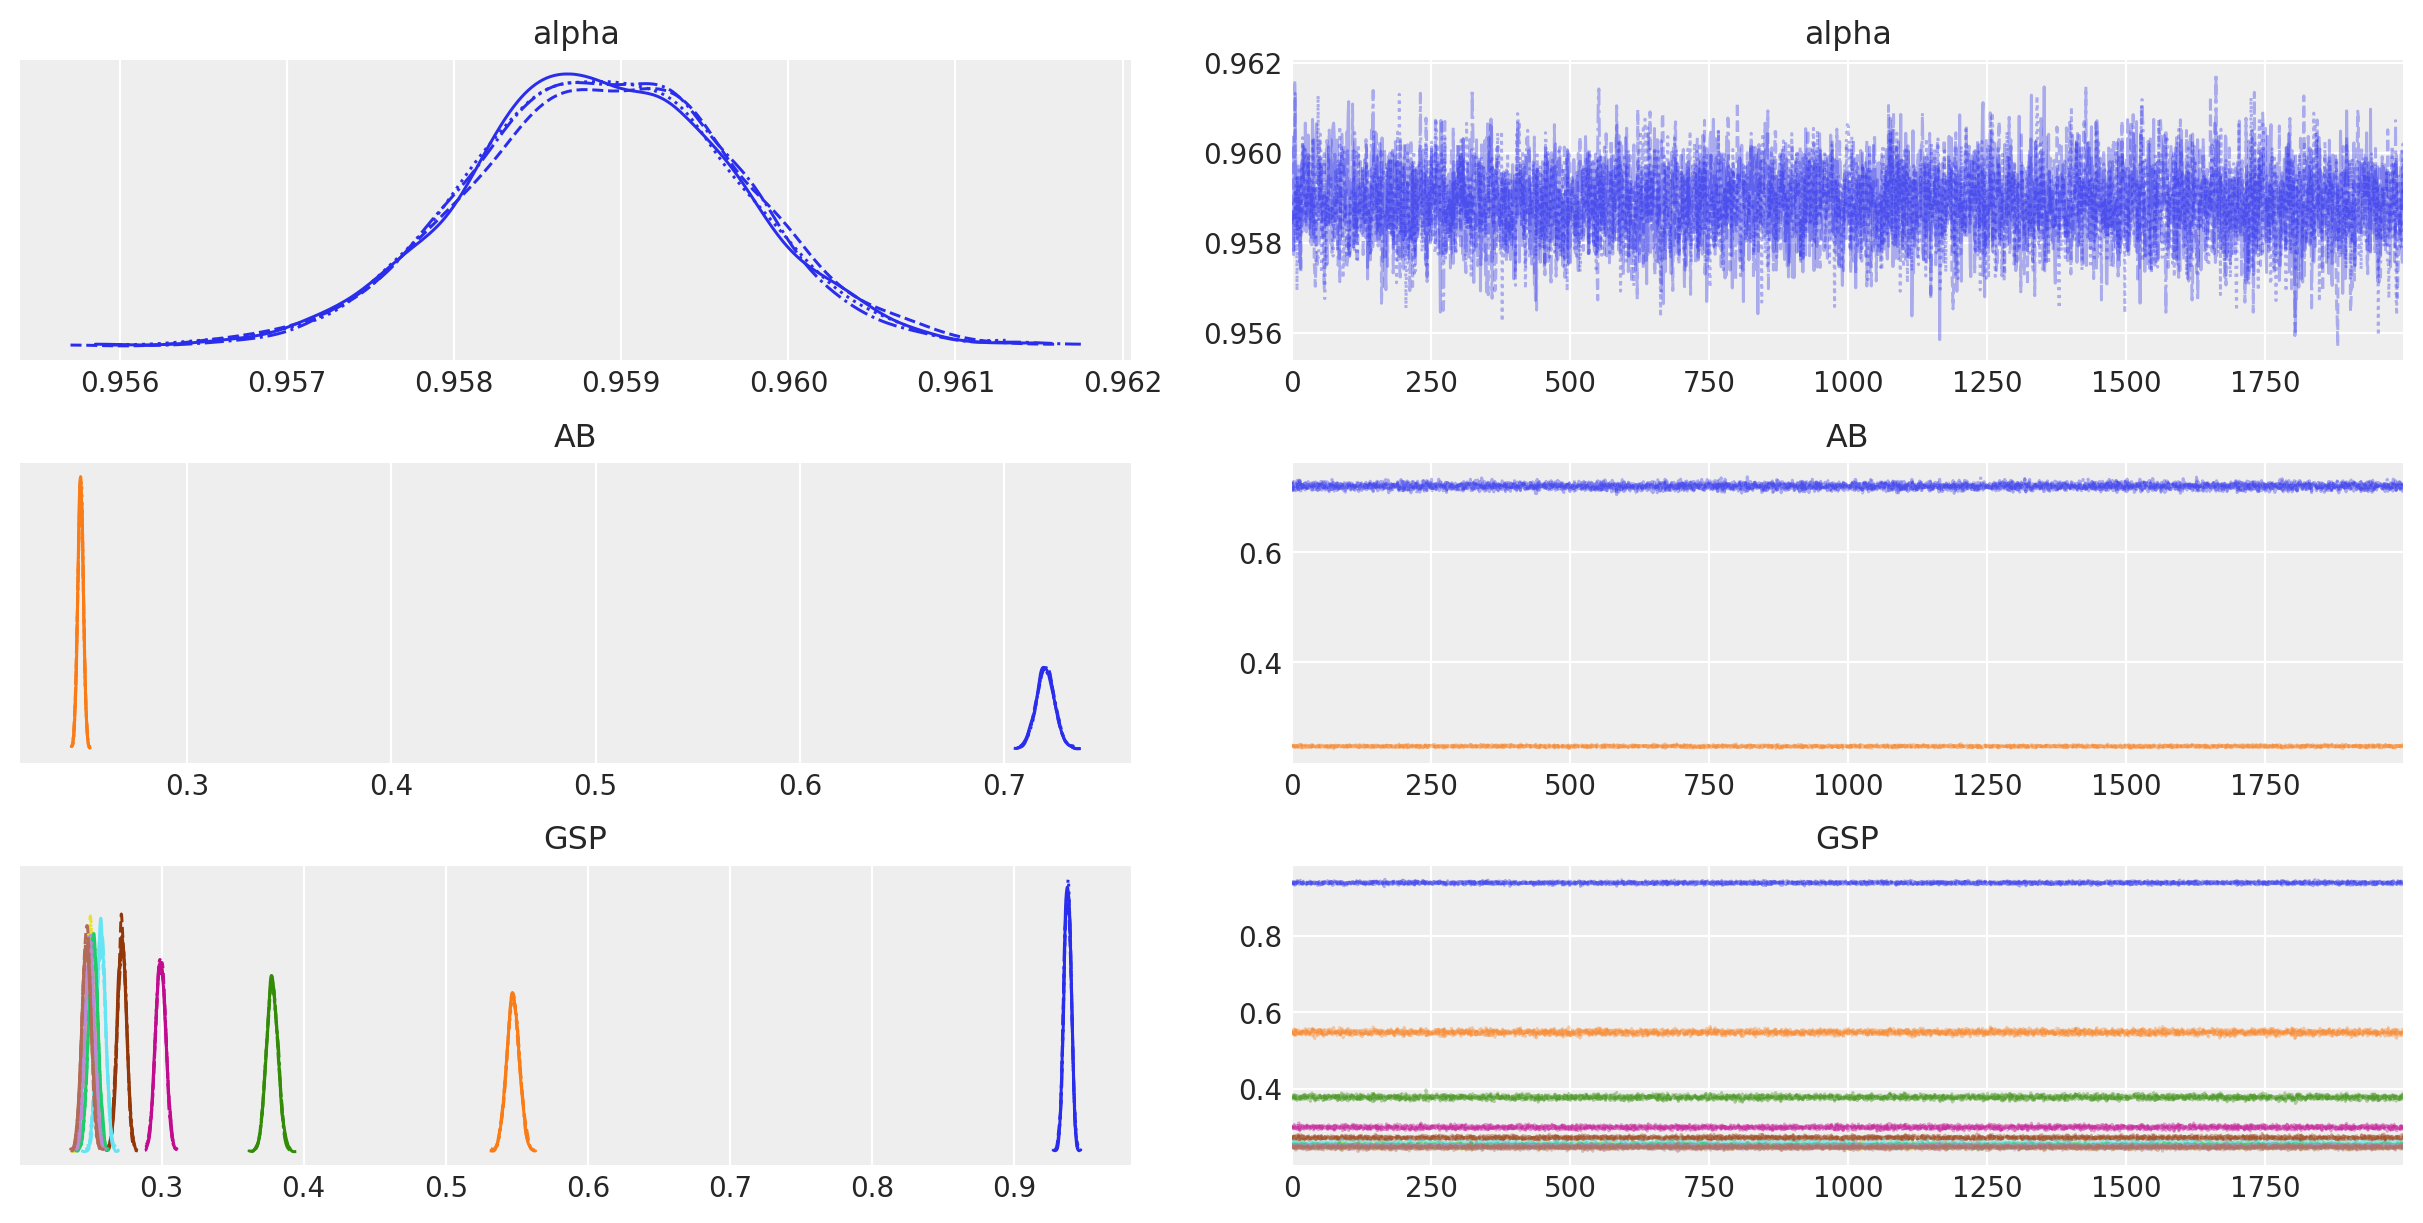

In [23]:
trace_h = get_trace(hierarchical)

In [24]:
azh_summary = get_summary(hierarchical, trace_h)
azh_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9589,0.0008,0.9574,0.9604,0.0000,0.0,4420.1325,5415.1467,1.0003
AB[0],0.7204,0.0045,0.7118,0.7285,0.0000,0.0,8615.3773,6379.3115,1.0001
AB[1],0.2477,0.0013,0.2451,0.2502,0.0000,0.0,6455.1960,6564.3479,1.0002
GSP[0],0.9377,0.0025,0.9331,0.9425,0.0000,0.0,9492.0207,6259.2742,1.0003
GSP[1],0.5474,0.0045,0.5387,0.5555,0.0001,0.0,6024.4704,6009.5384,0.9998
GSP[2],0.3779,0.0040,0.3700,0.3851,0.0001,0.0,6090.8791,5992.5484,0.9999
GSP[3],0.2993,0.0035,0.2930,0.3062,0.0000,0.0,8082.0929,6047.7687,1.0005
GSP[4],0.2721,0.0032,0.2659,0.2779,0.0000,0.0,10607.1285,5870.9549,1.0009
GSP[5],0.2574,0.0031,0.2515,0.2633,0.0000,0.0,11858.1632,6088.3299,1.0004
GSP[6],0.2500,0.0032,0.2440,0.2558,0.0000,0.0,10780.0147,6193.6722,1.0000


### compare models
ref: https://docs.pymc.io/notebooks/model_comparison.html

In [25]:
# Leave-one-out Cross-validation (LOO) comparison
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

/Users/shesha/anaconda3/envs/Qiskitenv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/shesha/anaconda3/envs/Qiskitenv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/shesha/anaconda3/envs/Qiskitenv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is le

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-427.570214,18.907303,0.000000,0.915615,38.627765,0.00000,True,log
hierarchical,1,-428.408485,22.606933,0.838271,0.084385,38.584874,1.41683,True,log


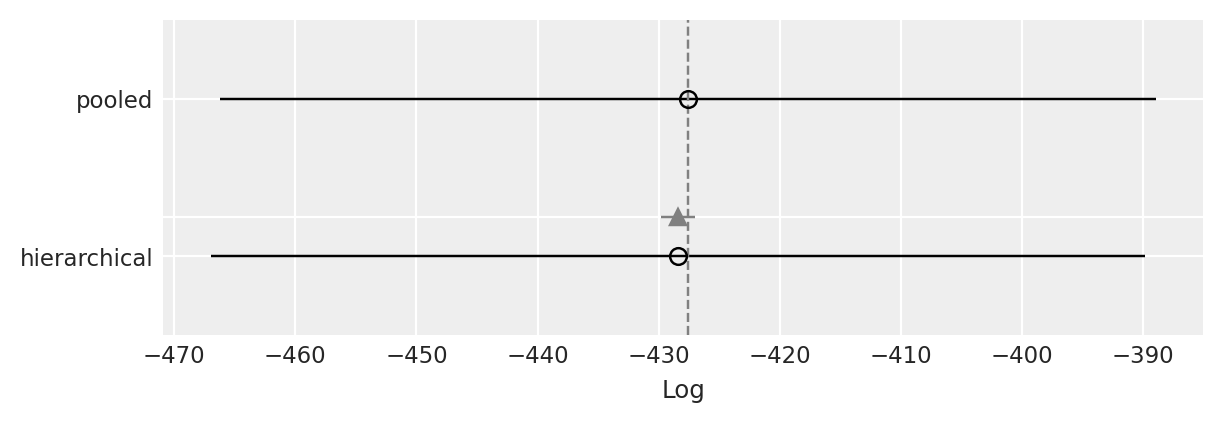

In [26]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [27]:
# predict EPC from the noisy model
pred_epc = get_predicted_EPC(error_source = 'depolarization')
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Number of u1 gates per Clifford: 0.129620 
Number of u2 gates per Clifford: 1.662976 
Number of u3 gates per Clifford: 0.165217 
Number of cx gates per Clifford: 1.491576 
Predicted 2Q Error per Clifford: 3.150458e-02


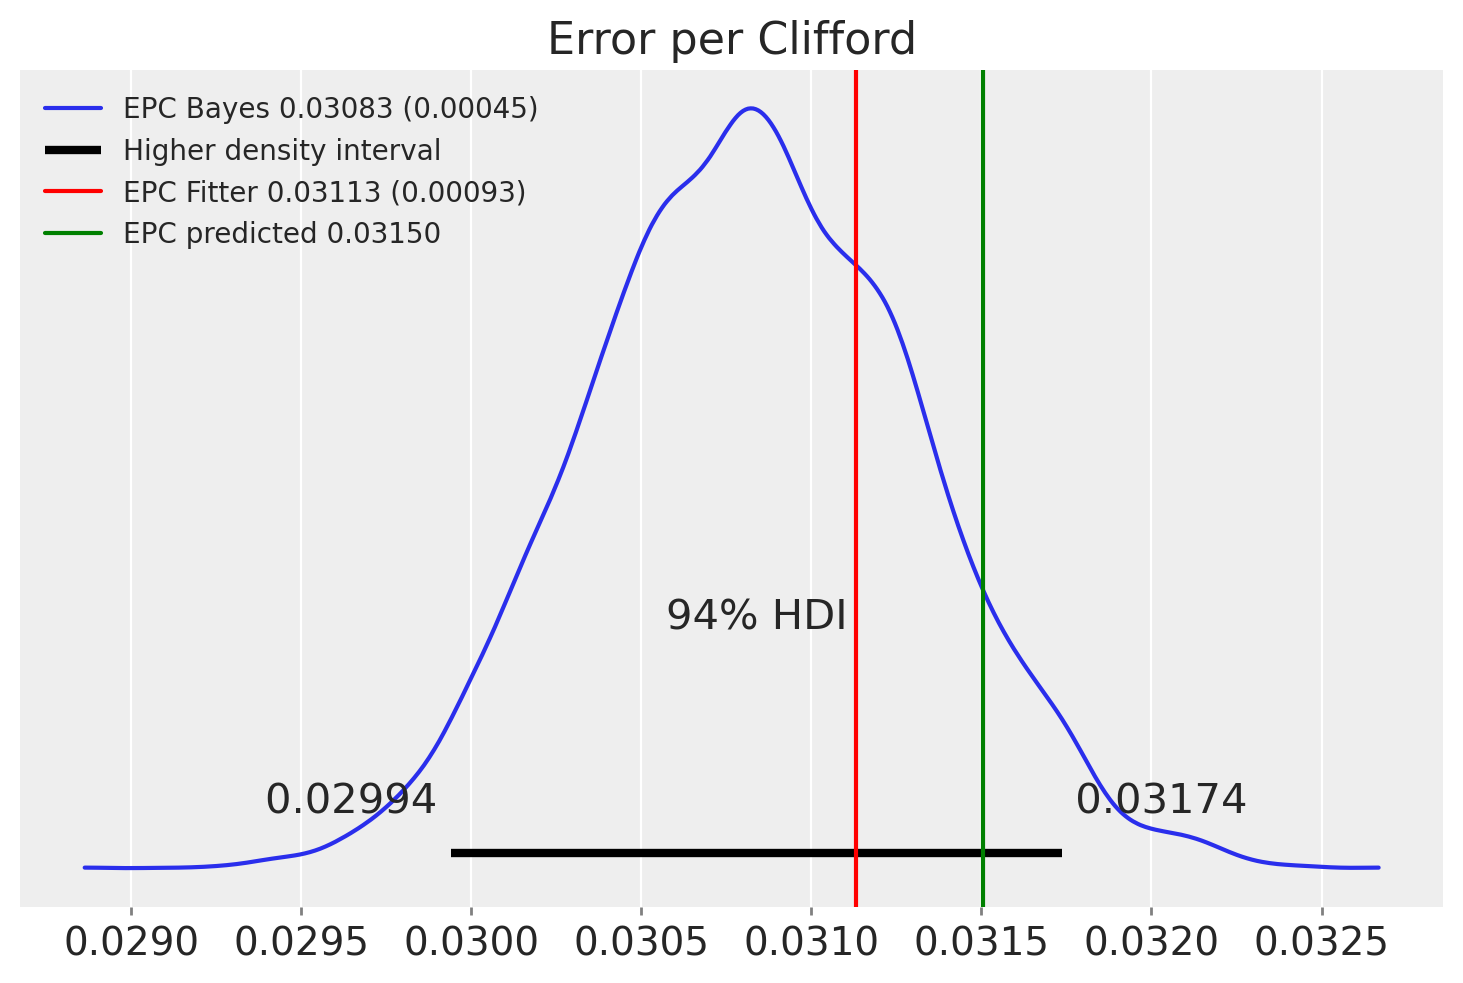

In [28]:
EPC_compare_fitter_to_bayes(pooled, azp_summary, trace_p)

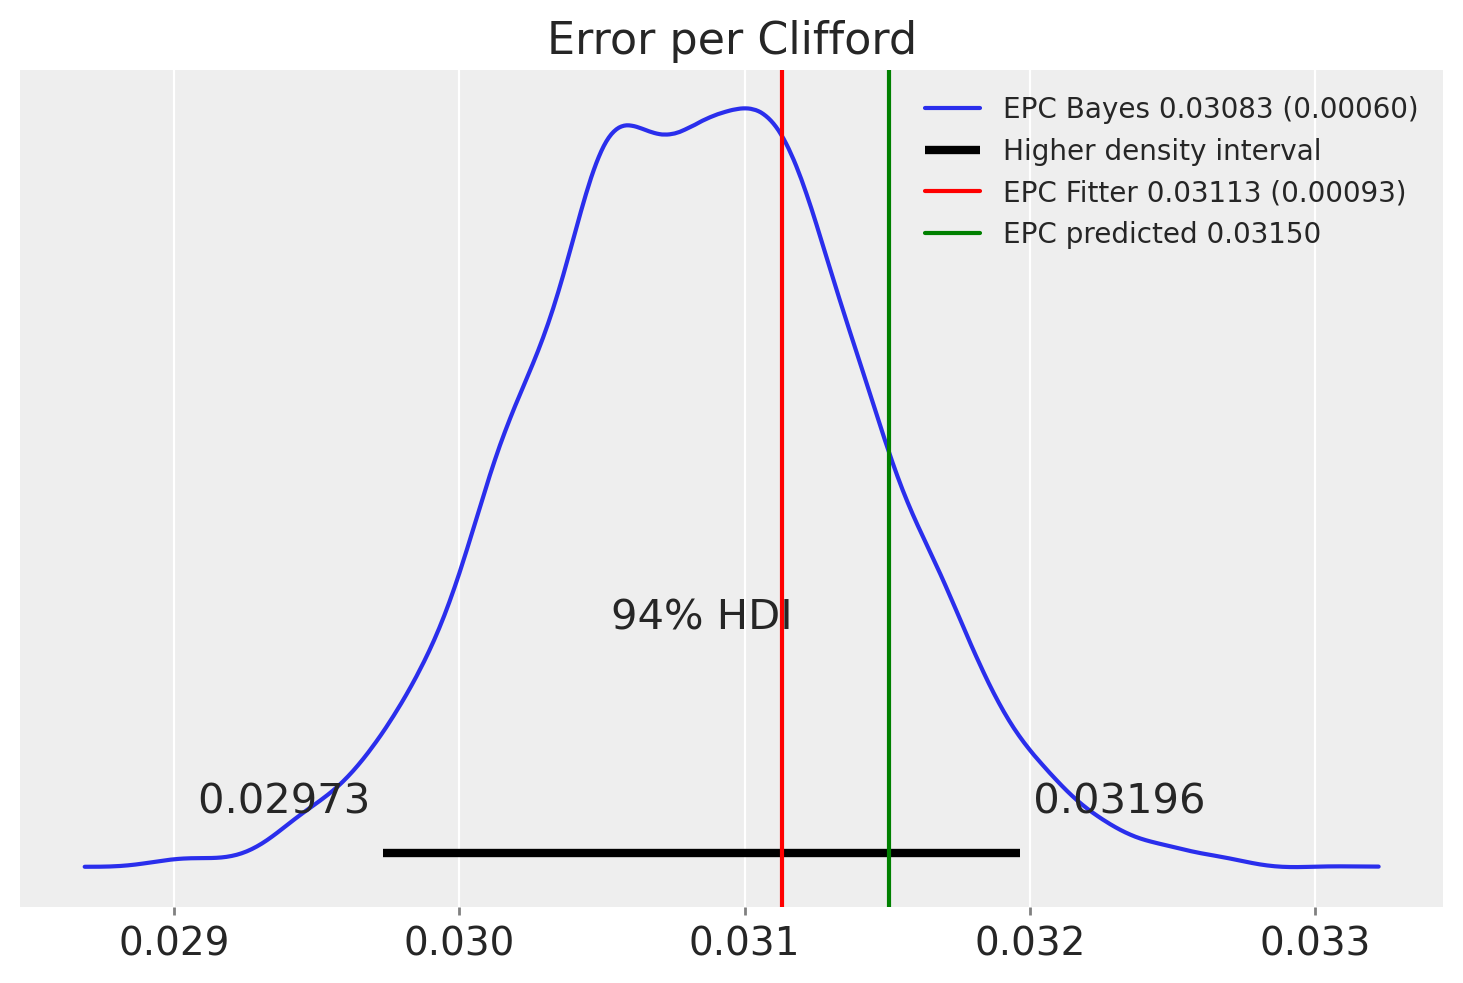

In [29]:
EPC_compare_fitter_to_bayes(hierarchical, azh_summary, trace_h)

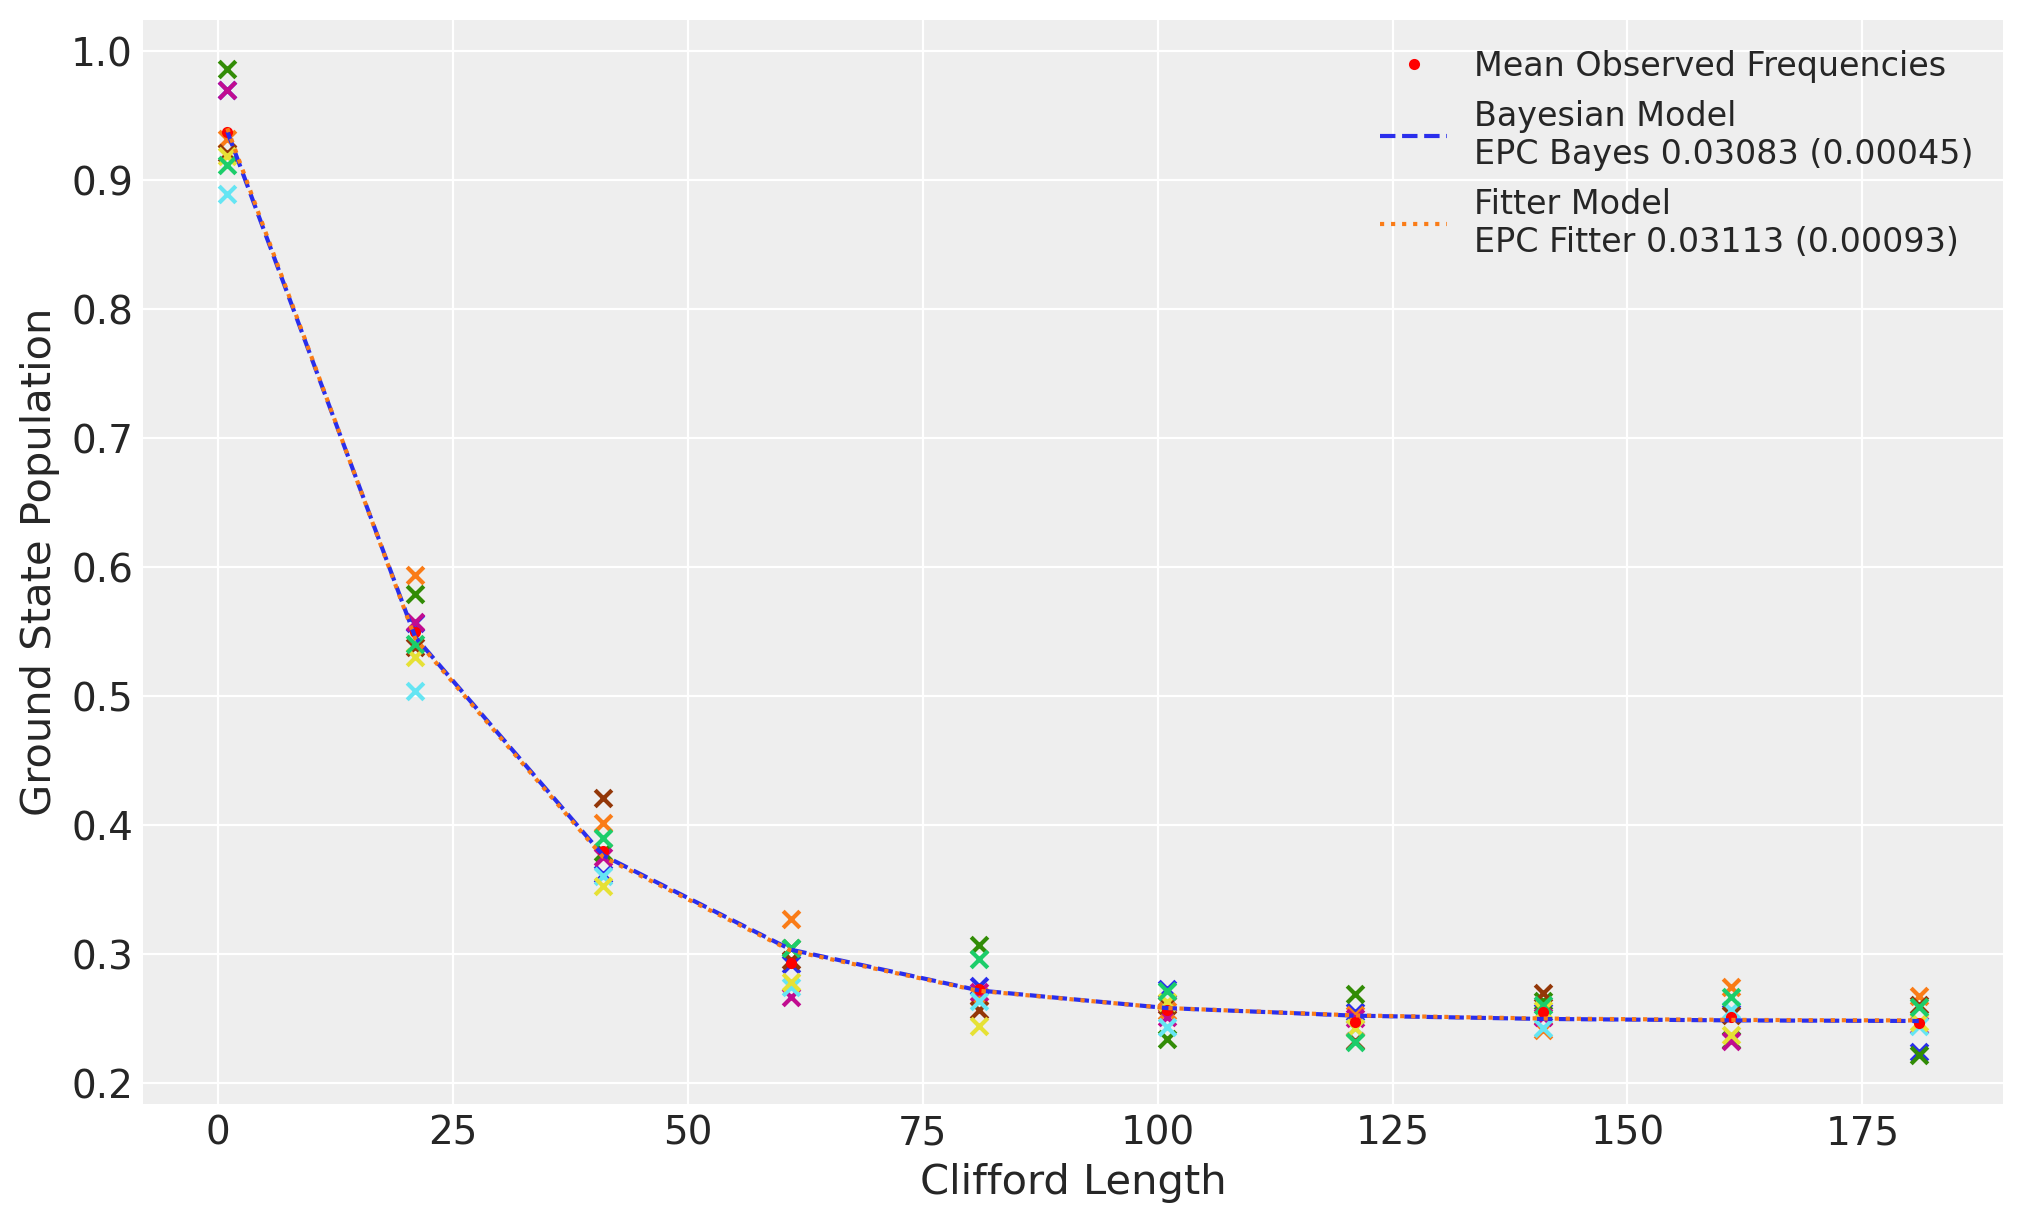

In [30]:
GSP_compare_fitter_to_bayes(pooled, azp_summary)

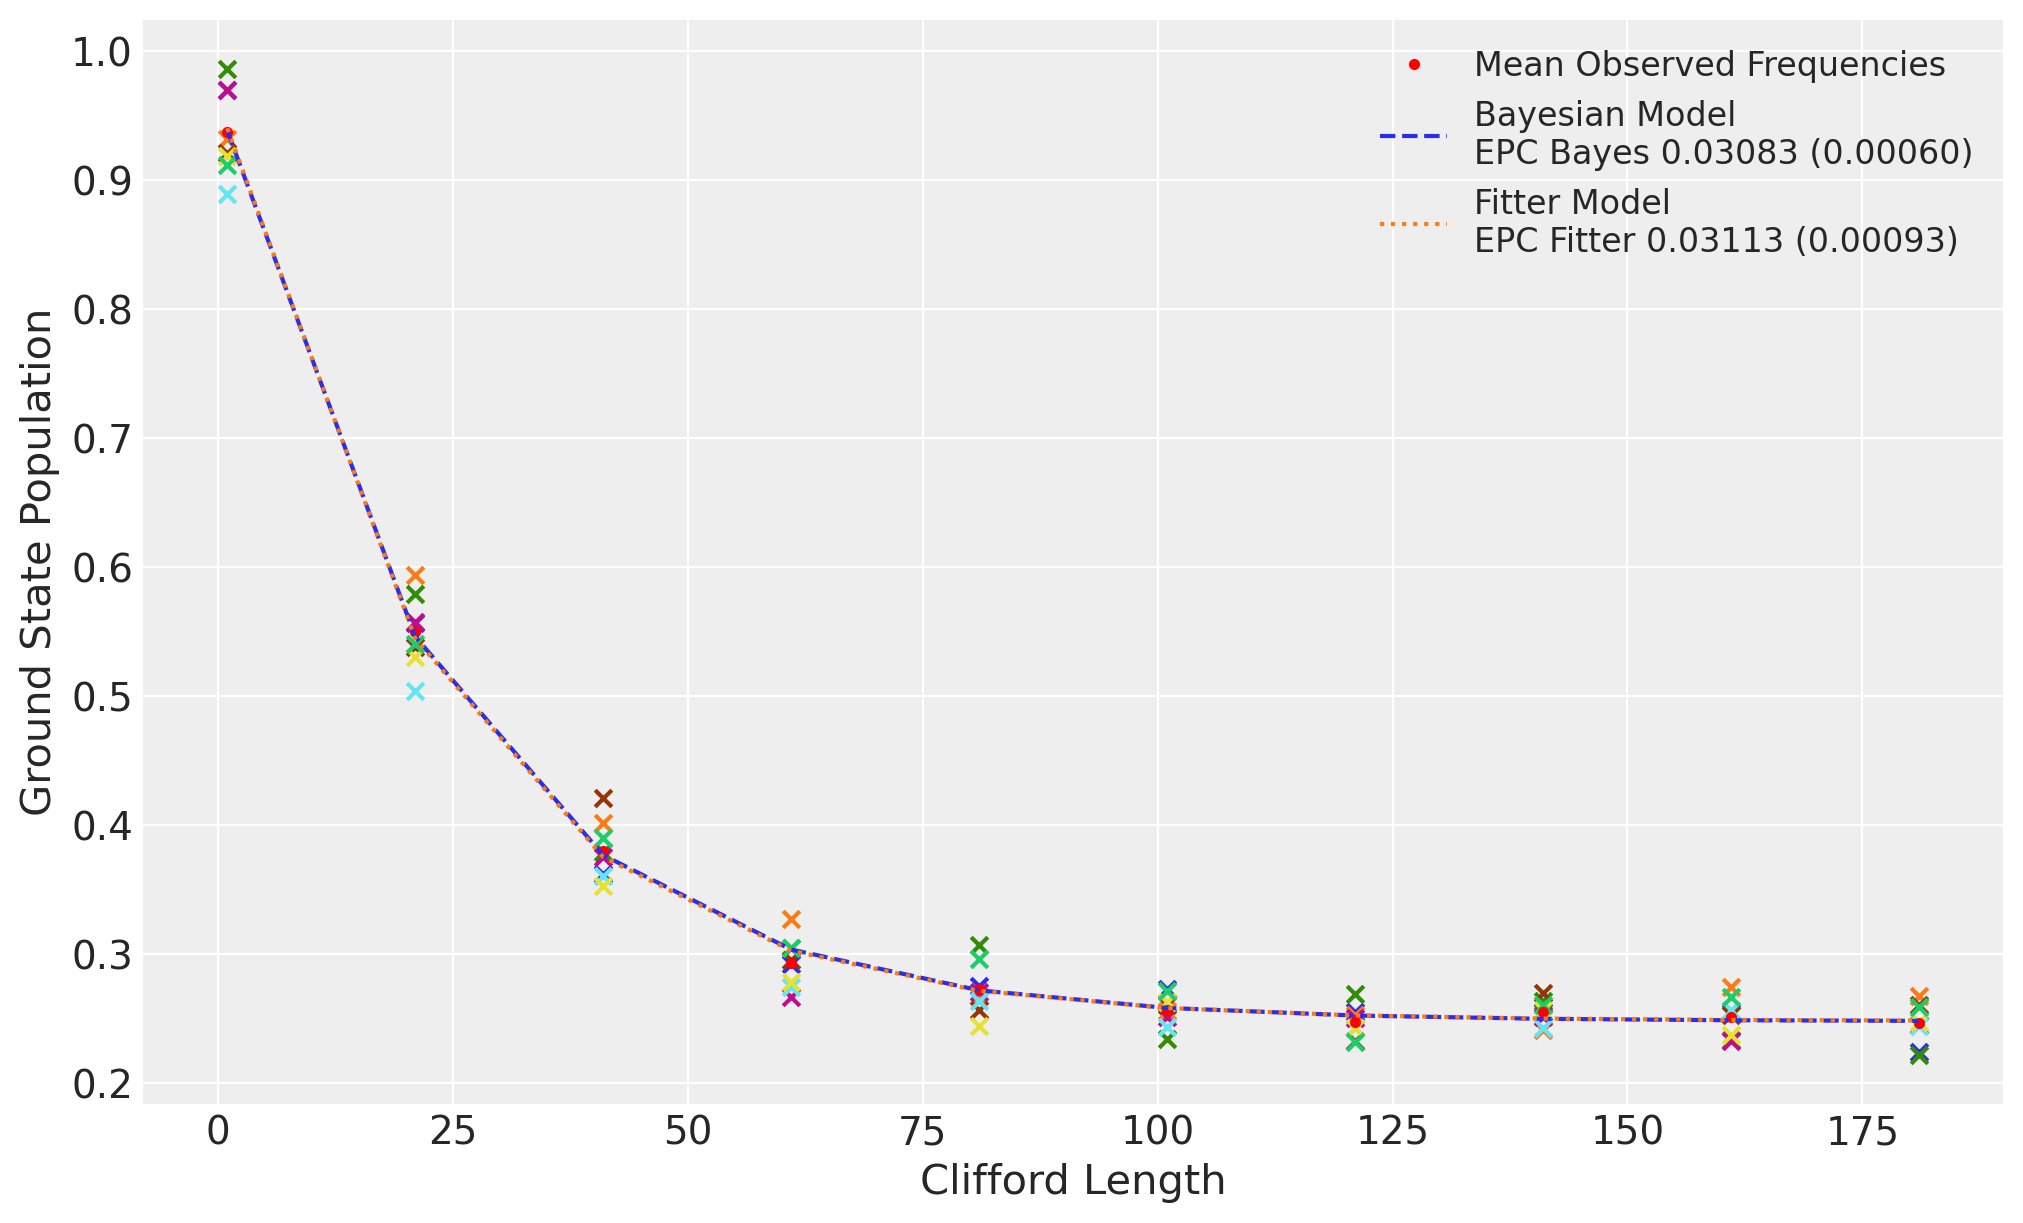

In [31]:
GSP_compare_fitter_to_bayes(hierarchical, azh_summary)

# 2. Run an RB Sequence with T1,T2 Errors
We now choose RB sequences that contain only 2-qubit Cliffords.

We execute these sequences as before, but with a noise model extended with T1/T2 thermal relaxation error, and fit the exponentially decaying curve.

In [32]:
#Number of qubits
nQ = 2
#There are 2 qubits: Q0,Q1.
#Number of seeds (random sequences)
nseeds = 10 # more data for the Rev. Mr. Bayes
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB Q0,Q1
rb_pattern = [[0,1]]
length_multiplier = 1

In [33]:
rb_opts  = {}
rb_opts ['length_vector'] = nCliffs
rb_opts ['nseeds'] = nseeds
rb_opts ['rb_pattern'] = rb_pattern
rb_opts ['length_multiplier'] = length_multiplier
rb_circs , xdata  = rb.randomized_benchmarking_seq(**rb_opts )

In [34]:
noise_model = NoiseModel()

#Add T1/T2 noise to the simulation
t1 = 100.
t2 = 80.
gate1Q = 0.2 # this was doubled with respect to the original example
gate2Q = 1.0 # this was doubled with respect to the original example
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

In [35]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024 # a typical experimental value
result_list = []
transpile_list = []
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    rb_circ_transpile = qiskit.transpile(rb_circ_seed, basis_gates=basis_gates)
    print('Simulating seed %d'%rb_seed)    
    job = qiskit.execute(rb_circ_transpile, noise_model=noise_model, shots=shots,
                         backend=backend, max_parallel_experiments=0)
    result_list.append(job.result())
    transpile_list.append(rb_circ_transpile)    
print("Finished Simulating")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Compiling seed 5
Simulating seed 5
Compiling seed 6
Simulating seed 6
Compiling seed 7
Simulating seed 7
Compiling seed 8
Simulating seed 8
Compiling seed 9
Simulating seed 9
Finished Simulating


In [36]:
print(rb_circs[0][0])

           ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐      ┌───┐ ┌───┐     ┌─┐»
qr_0: ──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├──■───┤ H ├─┤ S ├──■──┤M├»
      ┌─┴─┐└┬───┬┘├───┤┌─┴─┐└───┘└───┘ ░ └─────┘└───┘┌─┴─┐┌┴───┴┐├───┤┌─┴─┐└╥┘»
qr_1: ┤ X ├─┤ H ├─┤ S ├┤ X ├───────────░─────────────┤ X ├┤ SDG ├┤ H ├┤ X ├─╫─»
      └───┘ └───┘ └───┘└───┘           ░             └───┘└─────┘└───┘└───┘ ║ »
cr: 2/══════════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«         
«qr_0: ───
«      ┌─┐
«qr_1: ┤M├
«      └╥┘
«cr: 2/═╩═
«       1 


## Fit the RB results and calculate the gate fidelity <a name='fit_RB'></a>

### Get statistics about the survival probabilities

The results in **result_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

From $\alpha$ we can calculate the **Error per Clifford (EPC)**:
$$ EPC = \frac{2^n-1}{2^n} (1-\alpha)$$
(where $n=nQ$ is the number of qubits).

In [37]:
#Create an RBFitter object 
rbfit = rb.RBFitter(result_list, xdata, rb_opts['rb_pattern'])

##  Bayesian inference

In [38]:
m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(printout = True)

priors:
alpha_ref 0.9645425727292003
alpha_lower 0.9616577267252195 alpha_upper 0.967427418733181
A,B [0.73071526 0.25299966] 
cov A,B [2.17560919e-05 1.83998858e-06]
sigma_theta 0.004


### pooled model

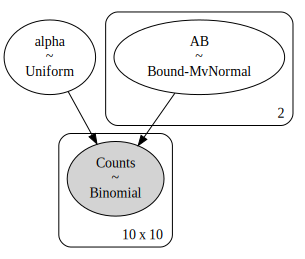

In [39]:
pooled = get_bayesian_model("pooled")
pm.model_to_graphviz(pooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 27 seconds.


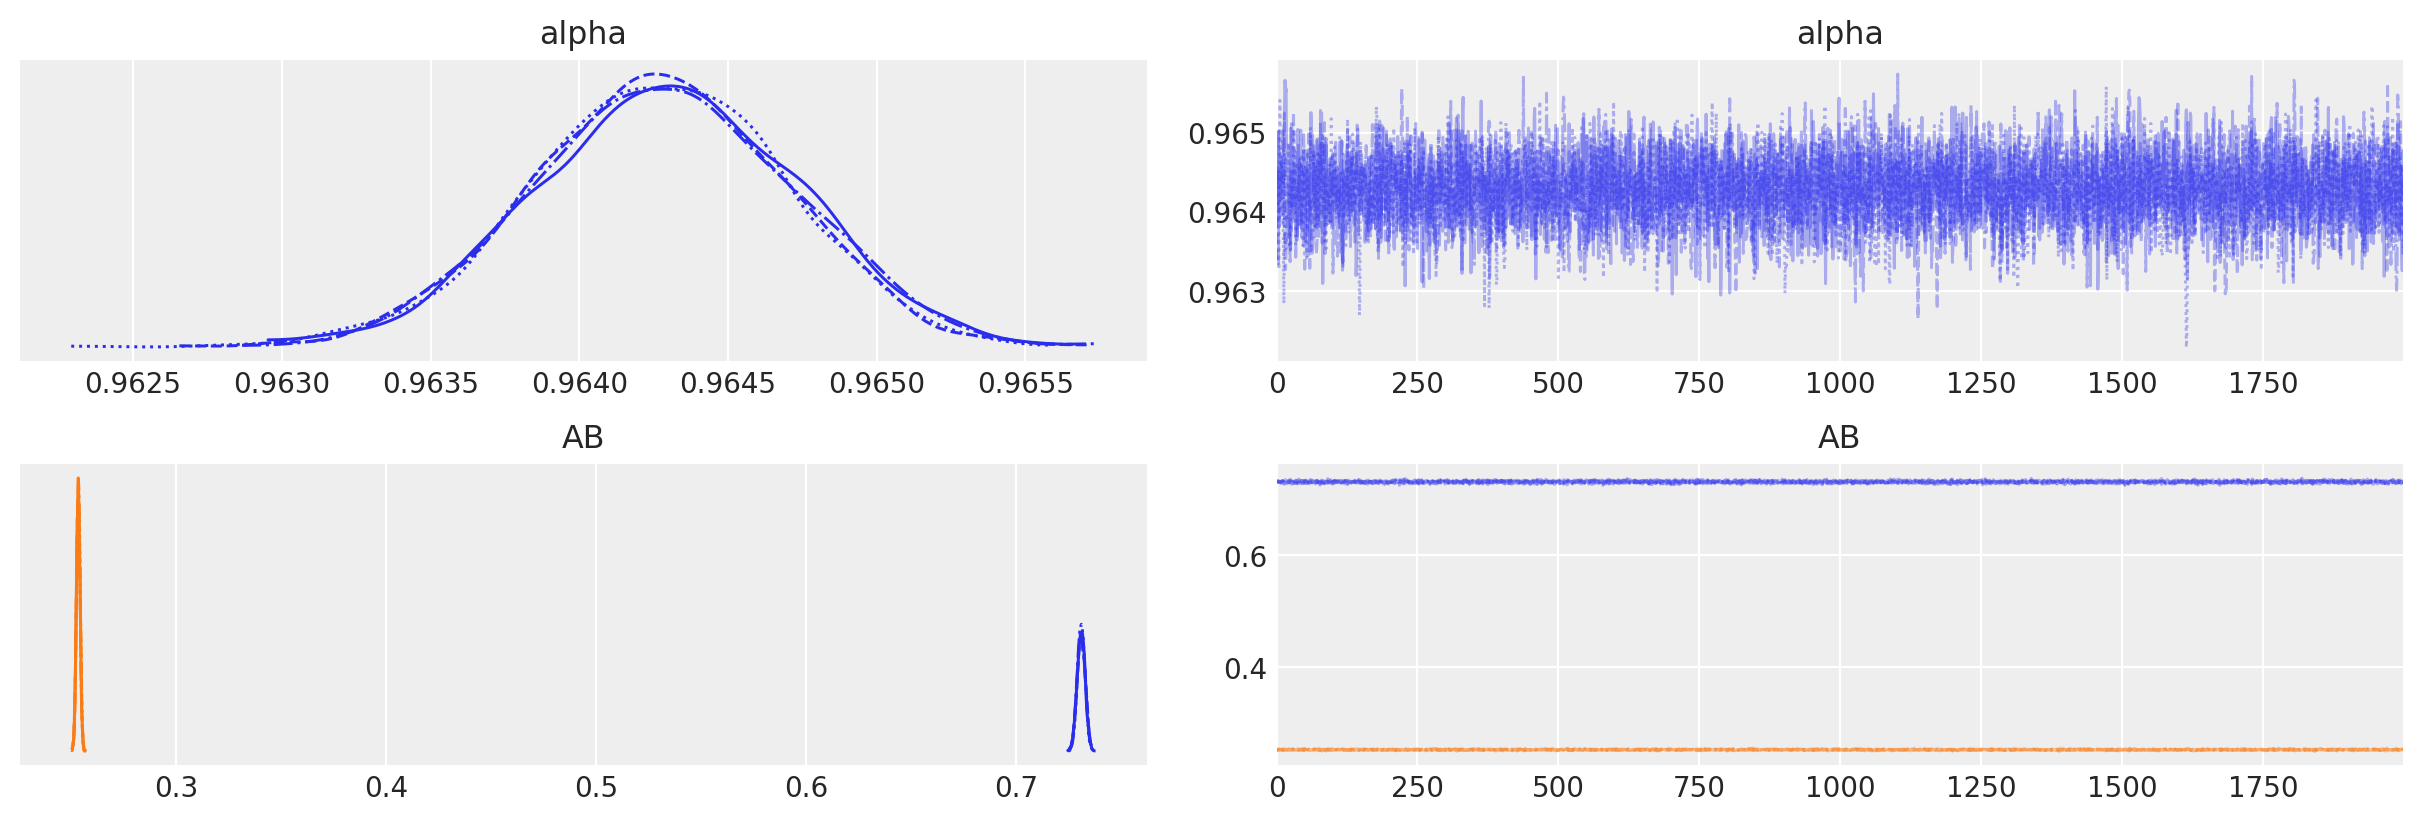

In [40]:
trace_p = get_trace(pooled)

In [41]:
azp_summary = get_summary(pooled, trace_p)
azp_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9643,0.0004,0.9635,0.9651,0.0,0.0,5859.2012,5437.5833,1.0006
AB[0],0.7311,0.0019,0.7276,0.7346,0.0,0.0,5903.1911,5761.1652,1.0005
AB[1],0.2533,0.0009,0.2516,0.2548,0.0,0.0,5815.3638,5707.1654,1.0003


### hierarchical model

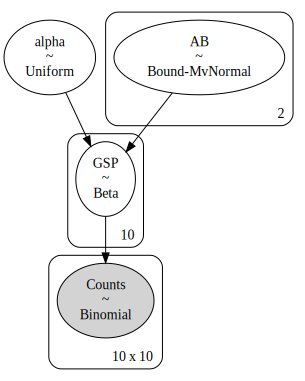

In [42]:
hierarchical = get_bayesian_model("hierarchical")
pm.model_to_graphviz(hierarchical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 37 seconds.


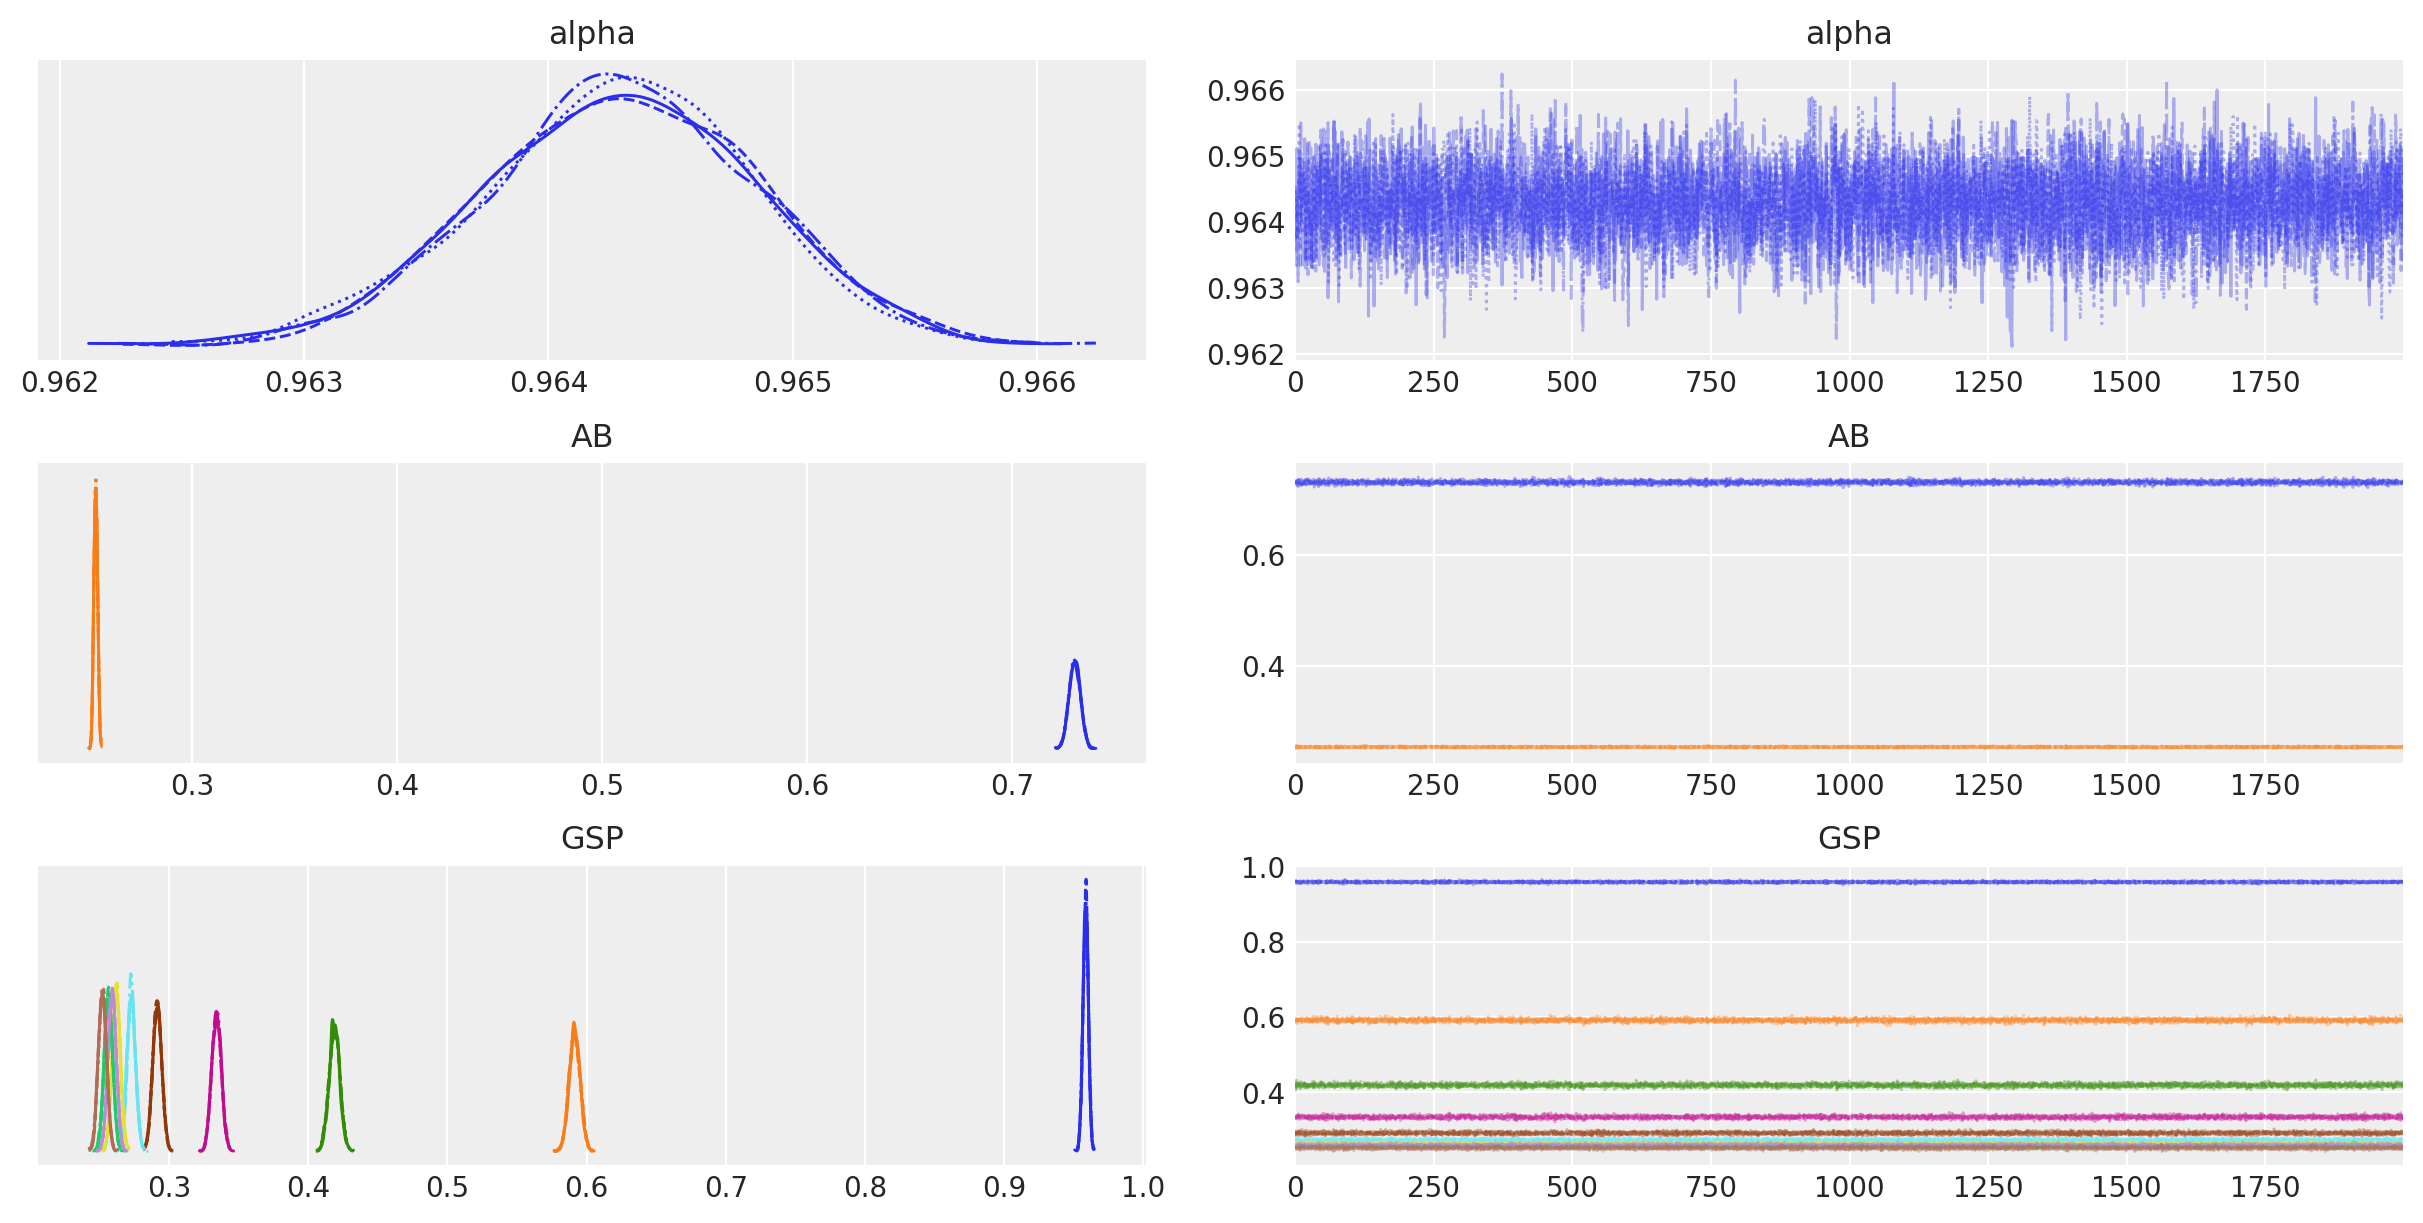

In [43]:
trace_h = get_trace(hierarchical)

In [44]:
azh_summary = get_summary(hierarchical, trace_h)
azh_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9643,0.0006,0.9632,0.9653,0.0,0.0,5249.7441,5754.1714,1.0005
AB[0],0.7306,0.0027,0.7256,0.7358,0.0,0.0,12442.9979,6546.2556,1.0004
AB[1],0.2532,0.0009,0.2515,0.2549,0.0,0.0,10569.5594,5600.7751,1.0000
GSP[0],0.9585,0.0019,0.9549,0.9620,0.0,0.0,13296.6397,6332.8483,1.0012
GSP[1],0.5914,0.0039,0.5841,0.5987,0.0,0.0,8022.2032,6460.0790,1.0001
GSP[2],0.4189,0.0038,0.4115,0.4260,0.0,0.0,7675.8978,6074.5373,1.0002
GSP[3],0.3341,0.0034,0.3277,0.3405,0.0,0.0,10164.5825,6461.5067,0.9998
GSP[4],0.2915,0.0032,0.2857,0.2976,0.0,0.0,10593.5947,6505.8279,1.0000
GSP[5],0.2729,0.0030,0.2674,0.2787,0.0,0.0,12030.2010,6621.3192,1.0013
GSP[6],0.2621,0.0030,0.2564,0.2678,0.0,0.0,15783.2219,5944.1626,1.0007


### compare models
ref: https://docs.pymc.io/notebooks/model_comparison.html

In [45]:
# Leave-one-out Cross-validation (LOO) comparison
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

/Users/shesha/anaconda3/envs/Qiskitenv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-453.533089,7.144834,0.000000,1.0,19.777840,0.000000,False,log
hierarchical,1,-456.128726,13.309291,2.595637,0.0,20.270239,1.740227,False,log


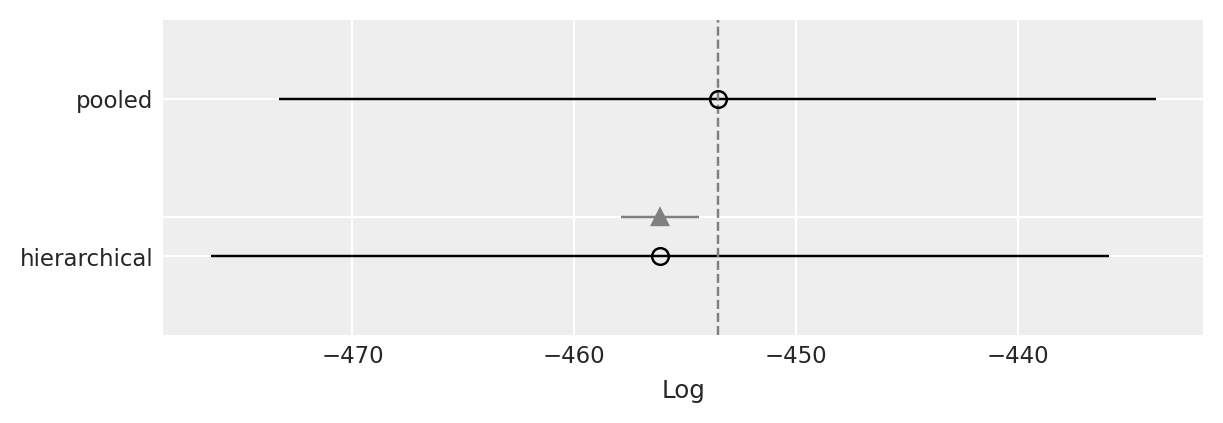

In [46]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [47]:
# predict EPC from the noisy model
pred_epc = get_predicted_EPC(error_source = 'from_T1_T2')
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Number of u1 gates per Clifford: 0.128804 
Number of u2 gates per Clifford: 1.646522 
Number of u3 gates per Clifford: 0.173370 
Number of cx gates per Clifford: 1.494348 
Predicted 2Q Error per Clifford: 2.601839e-02


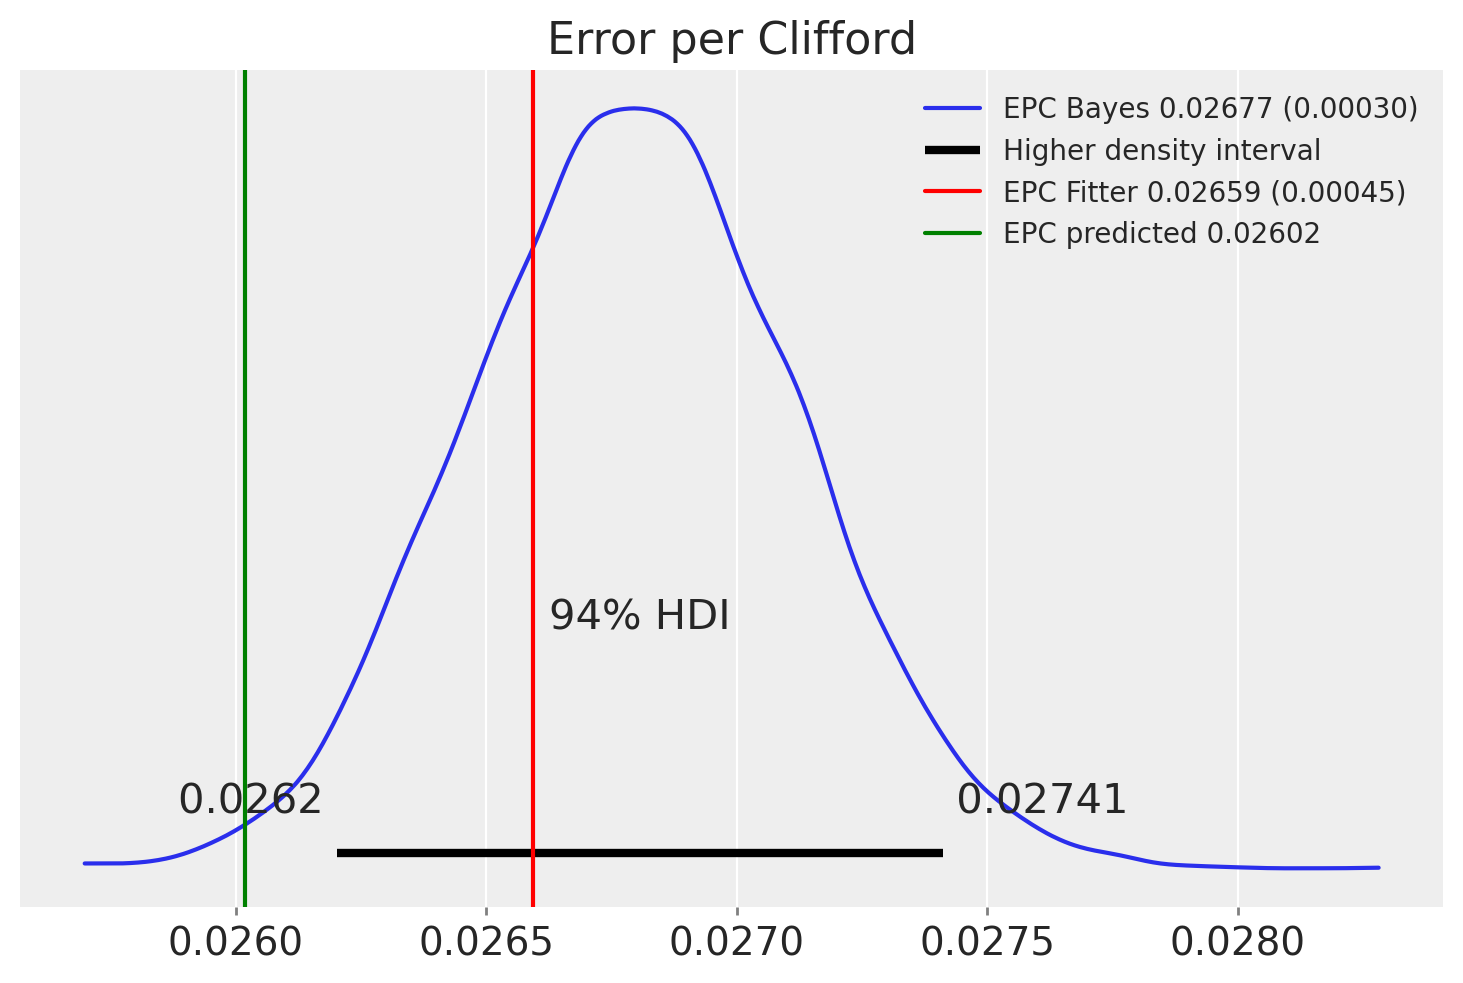

In [48]:
EPC_compare_fitter_to_bayes(pooled, azp_summary, trace_p)

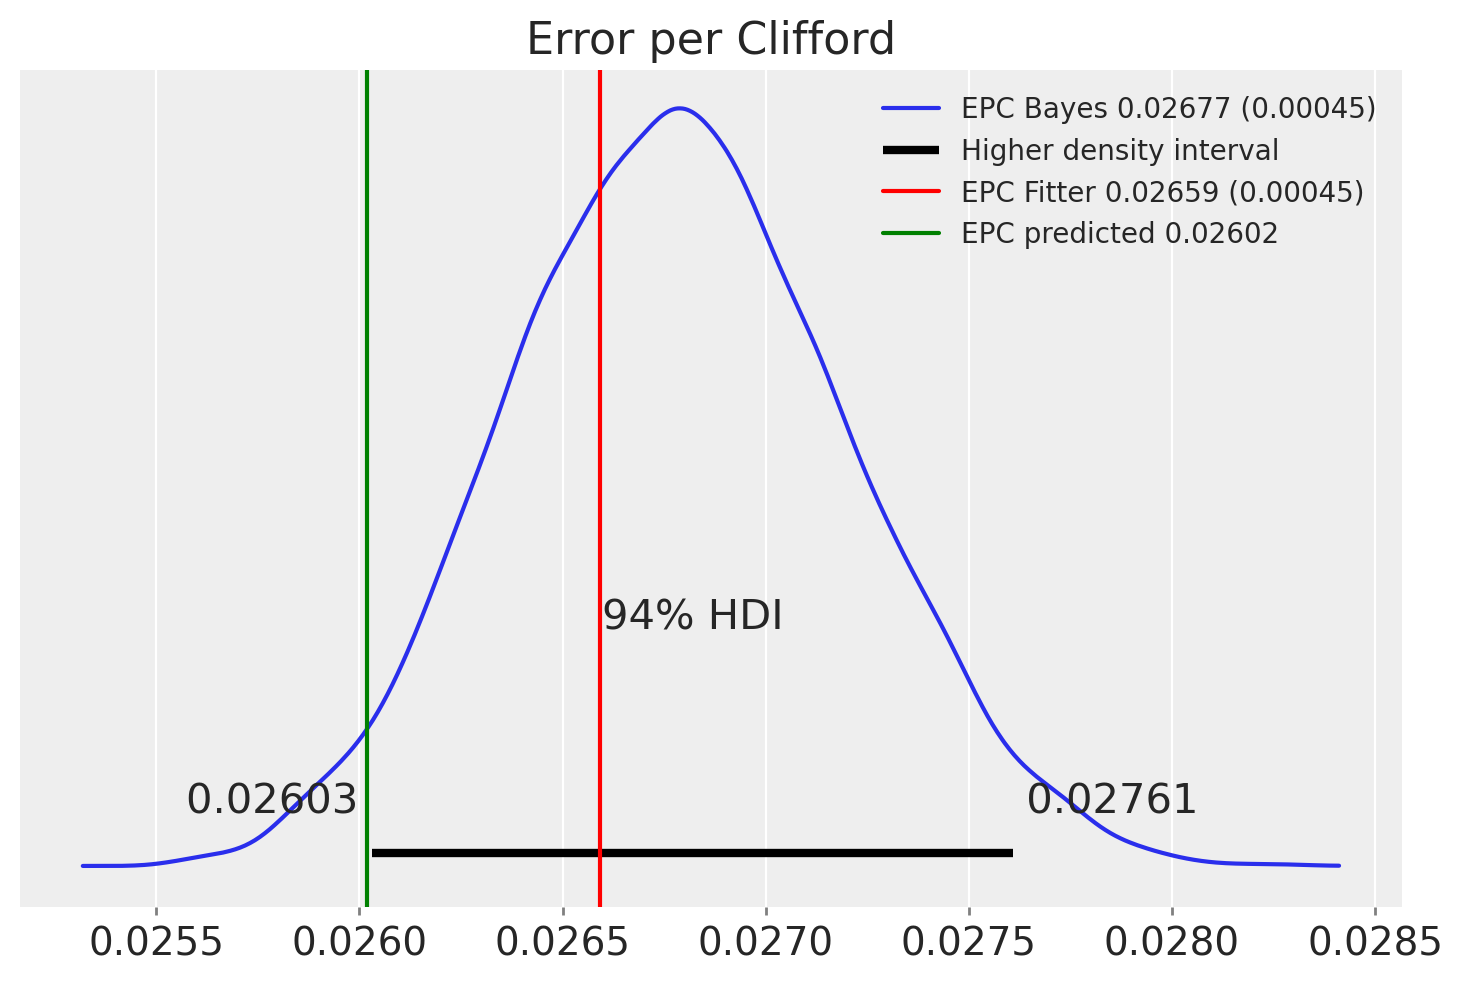

In [49]:
EPC_compare_fitter_to_bayes(hierarchical, azh_summary, trace_h)

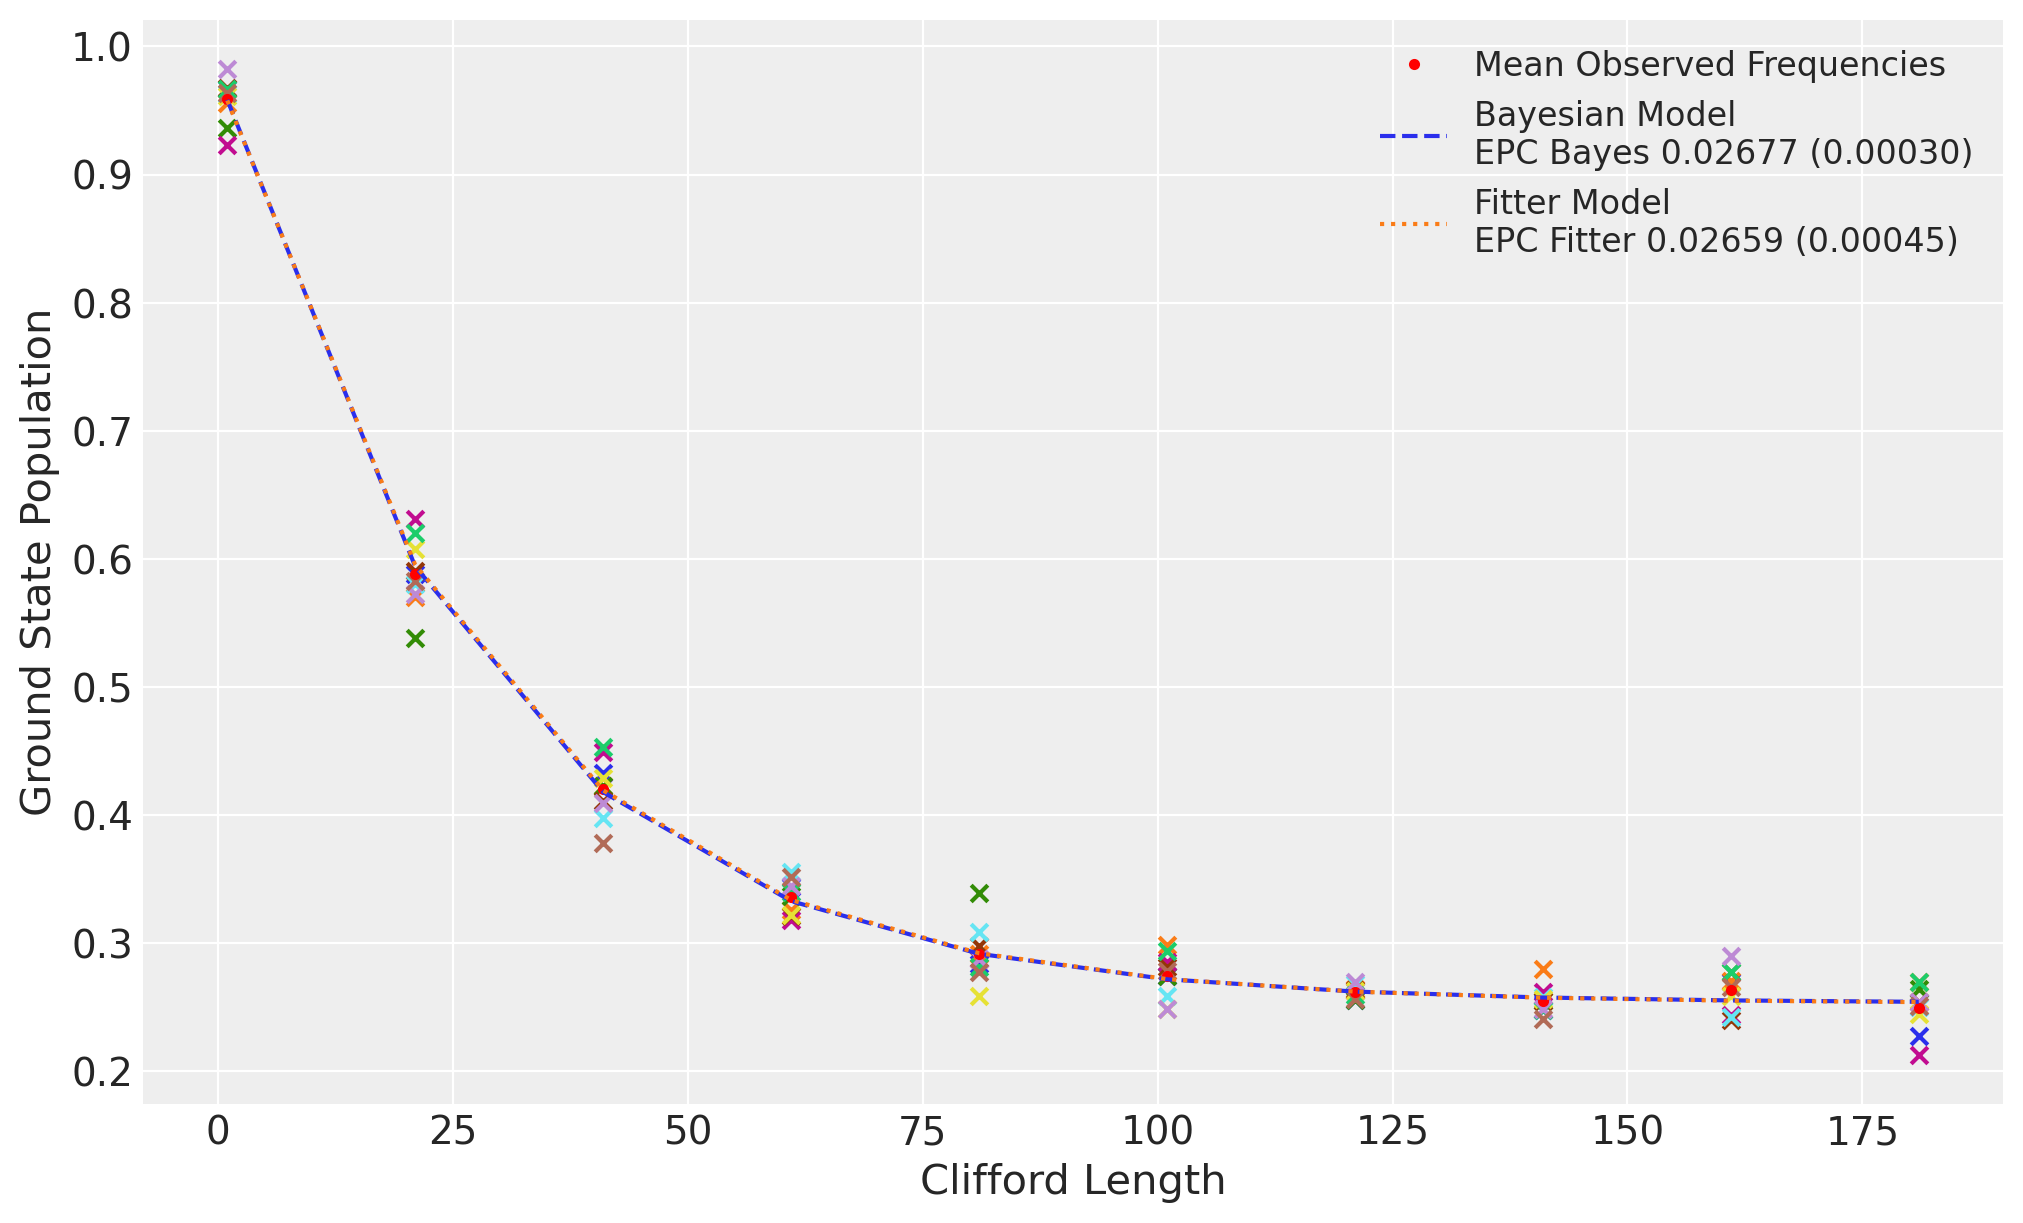

In [50]:
GSP_compare_fitter_to_bayes(pooled, azp_summary)

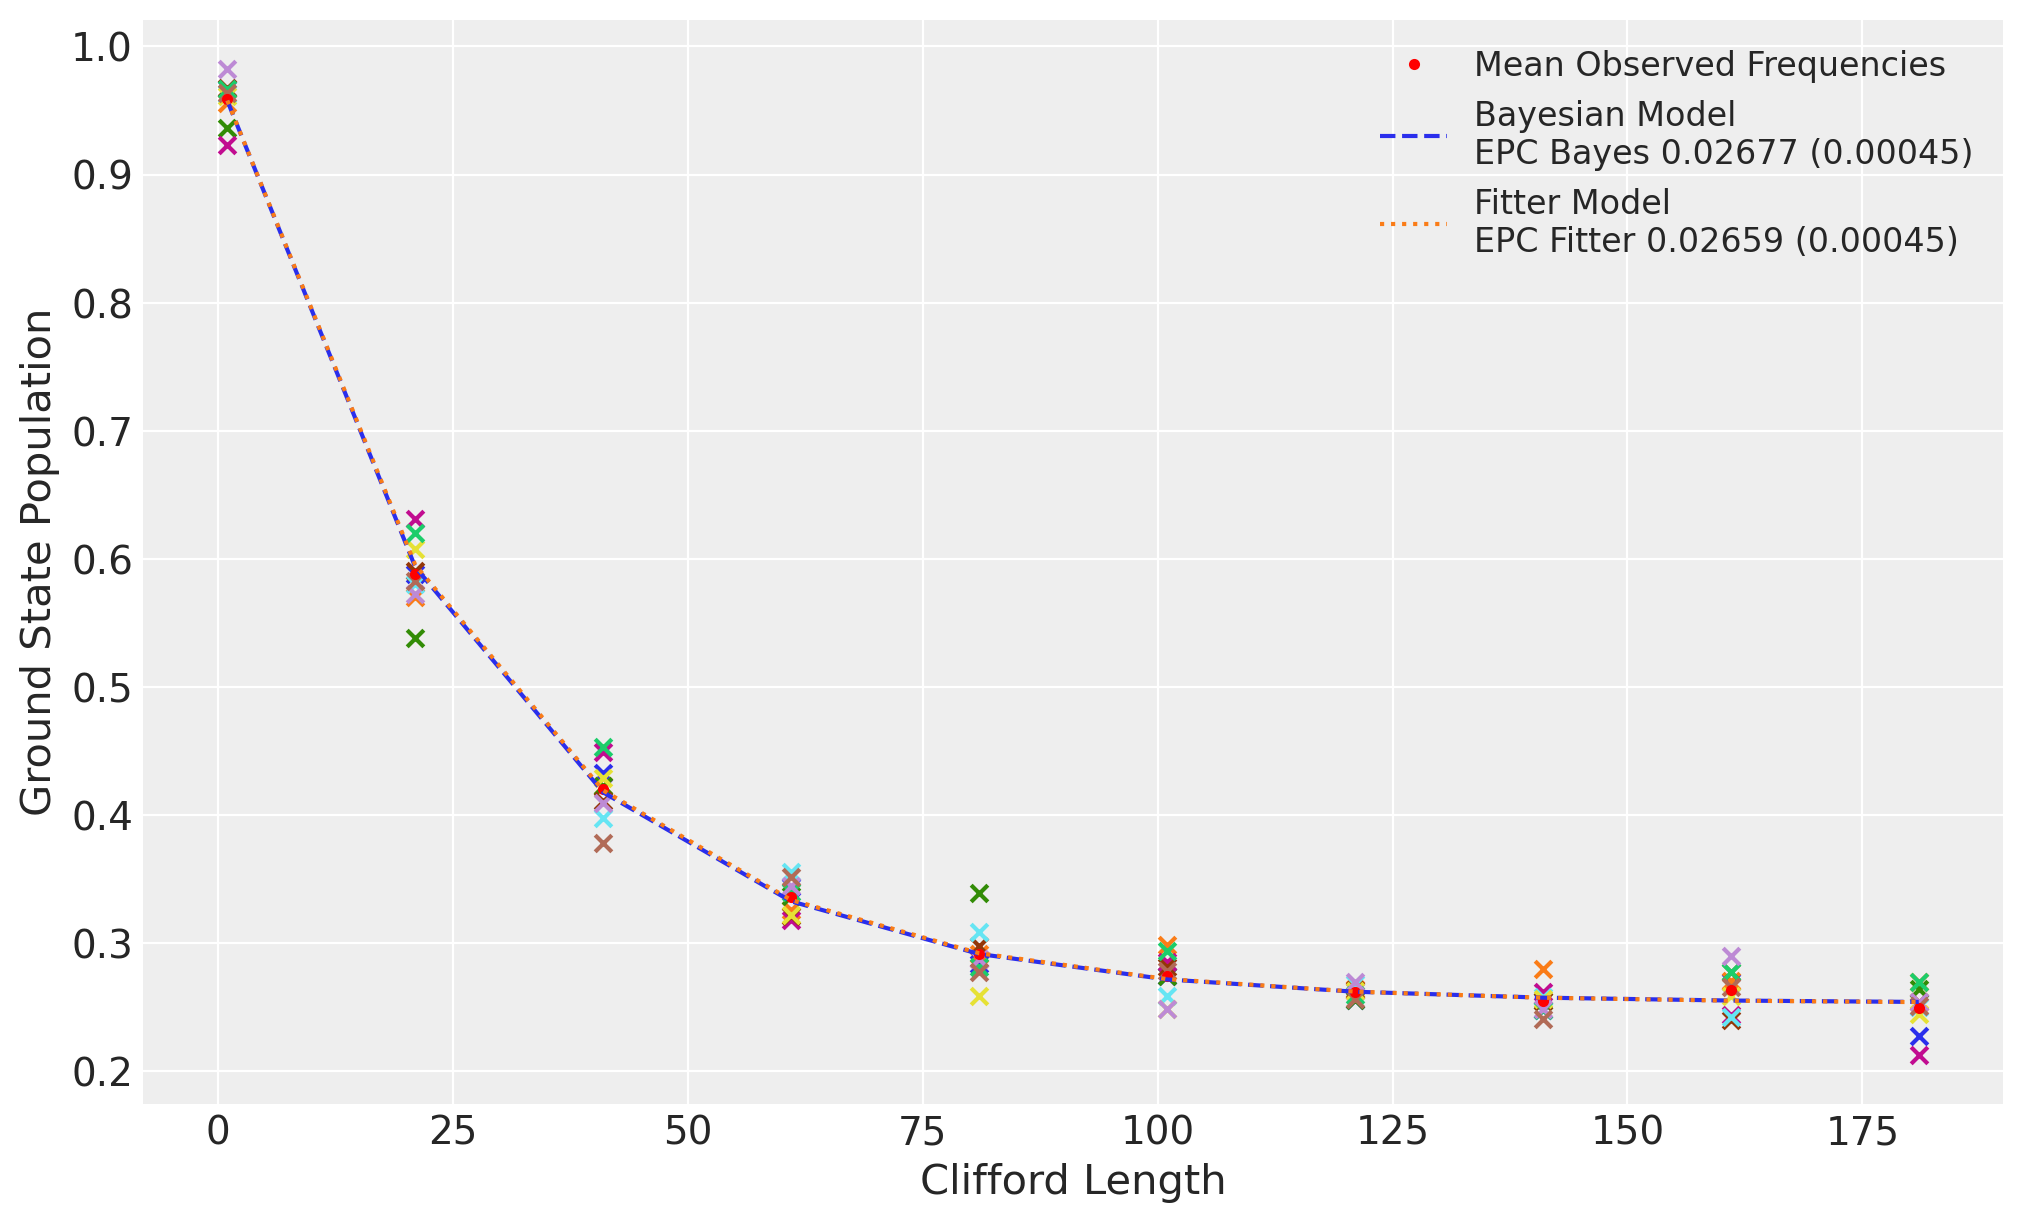

In [51]:
GSP_compare_fitter_to_bayes(hierarchical, azh_summary)

In [52]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Apr 01 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

pymc3     : 3.11.2
numpy     : 1.19.1
arviz     : 0.11.2
IPython   : 7.18.1
matplotlib: 3.2.2
qiskit    : 0.23.1

Watermark: 2.2.0

